In [1]:
# KPMG Forecasting Project
# LT Model
# Author: Kushal Wijesundara

In [2]:
import numpy as np
import pandas as pd
import datetime
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformers.single_series.detrend import Deseasonalizer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn import preprocessing
from reduce import order
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting._classes import MetricFunctionWrapper
import warnings
warnings.filterwarnings("ignore")  

In [3]:
df = pd.read_csv('data.csv', index_col=0)
df.index = pd.to_datetime(df.index)
colist = list(df.columns.values)

In [4]:
window = 72
steps = 18
split_date = "2018-06-01"

In [5]:
def target_forecast(val,var):
    reg_model = RandomForestRegressor(n_estimators=2*steps, max_depth=steps, random_state=2)
    pred = order([("1", Deseasonalizer(sp=len(fh), model="additive")),("2",ReducedRegressionForecaster(reg_model, 
                    strategy="recursive",window_length=window))])
    return pred

In [6]:
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.squeeze(), test_size=split)
def get_gscv(train):
    cv = SlidingWindowSplitter(
        initial_window=int(len(train)),
        start_with_window=True,
    )
    param_grid = {
        "n_estimators": [0.5*steps, steps, 2*steps],
        "max_depth": [0.5*steps, steps, 2*steps],
    }
    gscv = ForecastingGridSearchCV(pred, cv=cv, param_grid=param_grid, scoring=MetricFunctionWrapper(mean_absolute_error))
    return gscv

In [7]:
forecasts = []
for index, col in df.iteritems():
    col.index = col.index.to_period('M') 
    train, test = temporal_train_test_split(col, test_size=split)
    fh = list(range(1,1+steps))
    var = {'param':'avg'}
    avg = [.5] 
    for val in avg:
        pred = target_forecast(val,var)
        fh = fh
        pred.fit(train)
        pred = pred.predict(fh)
        forecasts.append(pred)
forecasts = pd.concat([pd.DataFrame(forecasts).T])
forecasts = forecasts.rename(columns=dict(zip(forecasts.columns,colist)))
forecasts.rename(columns={'EPS_10YR':'EPS_10YR_fore'}, inplace=True)
forecasts = forecasts.reset_index()
forecasts = forecasts.rename(columns={'index':'date'})
forecasts = forecasts.set_index('date')

In [8]:
y_ = forecasts.EPS_10YR_fore.values
x_ = forecasts.drop(forecasts.iloc[:, np.r_[1, 3:]], axis = 1).assign(constant=1).values
i = int(steps)
reg = []
for n in range(i,len(forecasts)):
    y = y_[(n - i):n]
    X = x_[(n - i):n]
    reg.append(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).dot(x_[n, :])) 

In [9]:
y_reg=pd.concat([pd.DataFrame(reg, columns=['EPS_10YR_reg'])])
fore_results = forecasts[['EPS_10YR_fore']].reset_index()
reg_results = fore_results.merge(y_reg, left_index=True, right_index=True)
reg_results = reg_results.set_index('date')
reg_results = reg_results[['EPS_10YR_reg']]
ensemble = pd.merge(forecasts,reg_results, how='outer', on='date').reset_index()
ensemble = ensemble.assign(EPS_10YR_pred = ensemble.loc[:, ["EPS_10YR_fore", "EPS_10YR_reg"]].mean(axis=1)).set_index('date')
LT_pred_results = ensemble[['EPS_10YR_pred']]
print(LT_pred_results)

         EPS_10YR_pred
date                  
2018-06       0.213364
2018-07       0.222711
2018-08       0.204850
2018-09       0.163273
2018-10       0.127553
2018-11       0.098188
2018-12       0.061230
2019-01       0.121115
2019-02       0.122816
2019-03       0.117678
2019-04       0.039379
2019-05       0.036445
2019-06       0.029382
2019-07       0.013187
2019-08       0.006856
2019-09      -0.006658
2019-10       0.084297
2019-11       0.068049


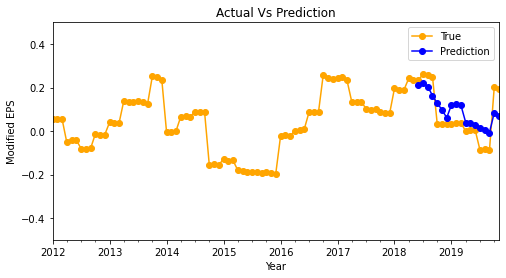

In [10]:
plt.figure(figsize=(8,4))
ax1 = df.EPS_10YR.plot(color='orange',label='True', marker = 'o')
ax2 = LT_pred_results.EPS_10YR_pred.plot(color='blue', marker='o', label='Prediction')
ax1.set_ylabel('Modified EPS')
ax1.set_xlabel('Year')
ax1.set_xlim([datetime.date(2012,1,1), datetime.date(2019,11,1)])
ax1.set_ylim([-0.5, 0.5])
plt.title('Actual Vs Prediction')
plt.legend()
plt.show()

In [11]:
#future forecast
df.index = pd.to_datetime(df.index).to_period('M')
split = len(df.loc[split_date:])/len(df)
train, test = temporal_train_test_split(df.iloc[:,-1], test_size=split)
future_forecasts = []
fh = list(range(1,1+steps))
var = {'param':'avg'}
avg = [.5] 
for val in avg:
    pred = target_forecast(val,var)
    fh = list(range(2*steps,3*steps))
    pred.fit(train)
    pred = pred.predict(fh)
    future_forecasts.append(pred)
f_forecasts = pd.concat([pd.DataFrame(future_forecasts)])
print(f_forecasts.T.reset_index())

      index         0
0   2021-05  0.088524
1   2021-06  0.091052
2   2021-07  0.088682
3   2021-08  0.069655
4   2021-09  0.058871
5   2021-10  0.044569
6   2021-11  0.033887
7   2021-12  0.029531
8   2022-01  0.089406
9   2022-02  0.085425
10  2022-03  0.085302
11  2022-04  0.015175
12  2022-05  0.009364
13  2022-06  0.014718
14  2022-07  0.022776
15  2022-08  0.018814
16  2022-09  0.013780
17  2022-10  0.107443
